# Rancher Based Modeling

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image
from IPython.display import display
import matplotlib.pyplot as plt

### For the final project in Space-Time Analytics I will be adding to an Agent Based Model of rancher stocking response to drought. The program Agent Analyst is used as an interface between the ABM program Repast and ArcGIS. It allows Repast to access data in the GIS, create agents and environments out of that, apply action and scheduling code that alters the data, then overwrite the data in the GIS and update the display for a continuous presentation of the phenomena that the ABM is simulating. The phenomenon we are looking at is the adoption of drought insurance by ranchers in response to drought. This is a precipitation-index based insurance product made available through the USDA's Risk Management Agency last year as means of supporting feed costs and mitigating against financial loss from lost grassland forage potential and reductions in cattle stock. The decision to purchase insurance will be based partly on simulated behaviors (that can verified or updated with actual data in the future) and actual data derived from historical precipitation records and cattle sale data from the last 10 years. The decision to purchase the insurance is considered to be based on need, with the largest indicator of such, in the data available to us, at least, being cattle sales. It is expected that there is a relationship between rainfall and cattle sales, with rising sales in response to dry conditions. This relationship will be the foundation of a decision function that each simulated rancher will use to decide to adopt insurance, which, once purchased, will provide a dampening effect on the amount of cattle that must be sold. Other factors and the conceptual code are described below:

Each time-step (1 month), each polygon agent will:

-assess their average precipitation levels and compare it to the average baseline precipitation (the “strike-level” that triggers payout) to see if they would have been eligible for a payout;

If precip < strike: coulda_count = 1 coulda_count = coulda_count + 1

-look back and see how many times they could have had a payout and if it reaches a certain ratio we could add that as a decision weight for whether or not to buy insurance.

    If coulda_count / timestep_count > .5 (any threshold ratio):
        woulda_count = woulda_count + 1 ( adding to our weight counter)
        
-Assess what ratio of neighbors have taken out insurance this year, or still has insurance this year, to the overall number of neighbors. Then, if the ratio reaches a certain threshold we will add weight of neighborhood to the decision equation.

    If neighbors_did > .5 #(or any threshold ratio):
        shoulda_count = shoulda_count.timestep[:-2] + 1
(We could also base this on a ratio, as in the more neighbors who have it the more likely the rancher is to buy it)

-Assess the amount of precipitation, and adjust their stocking rate accordingly by selling cows, buying cows or doing nothing. If he has to sell off a certain ratio of his stock we will add a weight of lost revenue to the decision equation. We will have to find an equation that tells us how much cattle they would sell at each at each precipitation level (drought_effect). This may not be field, we will probably need to include the equation

    stock = stock + (roundup(stock * (drought_effect)/stock)
        If roundup(stock * (drought_effect)/stock  >  5 (a loss_tolerance):
            Stockweight_count = stockweight_count + 1
-If the agent has insurance, it will provide a dampening effect on the amount of stock he must sell, or might also add to how much he buys . If we have time we could use this to decide whether or not he would buy better insurance (higher strike-level and liability)

-Finally, take into account his situation, weigh his options (buy or not buy) and decide whether or not to do it. Also, maybe how much insurance to take out and at what strike level.

    Maybe_should = some function of (woulda_count,shoulda_count and Stockweight_count)

    If maybe_should > thats_it: 
        self.insured = True

###    I chose Georgia as a trial run state because it had enough data points to create plenty of neighbors for the neighbor influence effect and I was assuming that there was enough contrast in precipitation over time with which to build a drought effect function for use in simulating cattle sales. Georgia is not typically susceptible to drought compared to the western states, but has been experiencing it lately.
 ###   Each zone within this map is a Thiessen polygon generated from the locations of the cattle auctions represented in the dataset. This is used to simulate individual ranches because we don't have data on that scale. Below is an image from a successful trial run meant to check that the ABM is successfully interfacing with the GIS while simulating zones where a payout would have been possible, given insurance, at each time step.
 ### The next challenge is have the ABM call on the actual monthly precipitation values, previewed below, and generate the drought function by which each simulated ranch stock will respond. Once I have these two elements, I am hoping that the decision factors will be relatively simple to incorporate. 

In [3]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='images/Drought_Monitor.png'></td><td><img src='images/pdi1895.png'></td></tr></table>"))

,


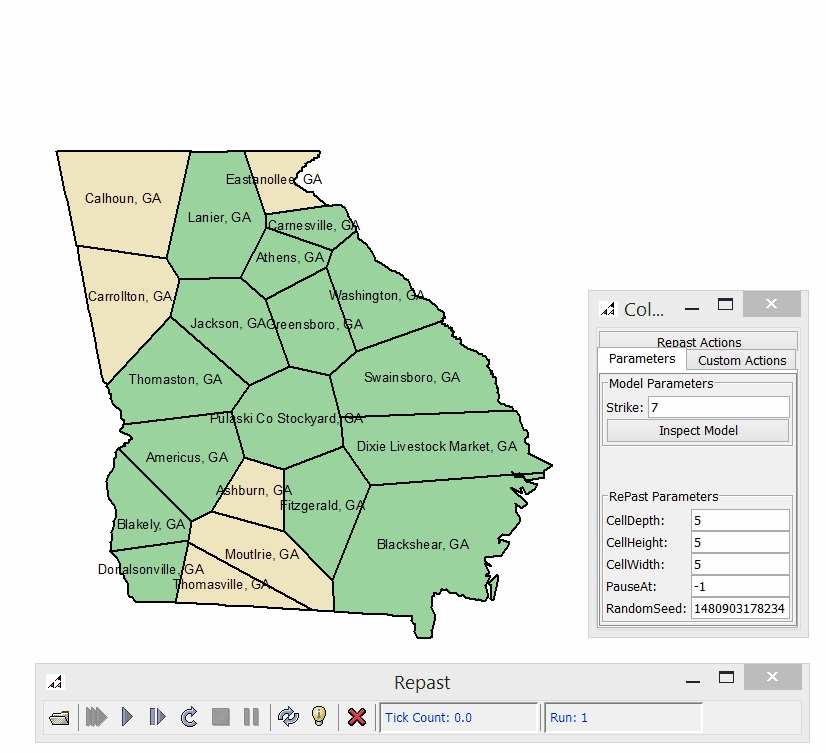

In [4]:
Image('images/Trial_run.jpg',width = 400, height = 400)

Below is the table I would like to use for the ABM, it contains average precipitaion at each cattle sale zone for each
monthly interval.

In [2]:
df = pd.read_csv('data/ranchers.csv')
df.head()

,FID,location,F1,F2,F3,F4,F5,F6,F7,F8,...,F124,F125,F126,F127,F128,F129,F130,RANCHER_ID,COLOR,PrecipAv
0,0,"Eastanollee, GA",86.71,225.99,262.60,99.63,104.90,61.62,125.59,166.01,...,106.23,111.01,128.26,186.59,99.81,75.34,92.03,0,GREEN,101.82
1,1,"Carrollton, GA",119.67,105.11,79.16,79.28,98.13,53.33,75.03,72.35,...,94.85,98.72,48.23,79.42,108.02,109.23,120.05,1,GREEN,96.12
2,2,"Greensboro, GA",105.75,116.64,83.71,80.62,87.32,135.00,90.02,36.66,...,82.33,104.19,89.30,75.69,71.81,97.57,135.48,2,GREEN,94.20
3,3,"Jackson, GA",125.05,59.53,96.11,73.40,127.73,153.99,160.75,138.75,...,74.24,76.16,50.72,69.00,92.11,81.41,125.61,3,GREEN,95.07
4,4,"Swainsboro, GA",106.83,79.37,88.31,157.49,135.15,33.33,97.03,73.49,...,112.63,78.05,90.51,55.28,52.82,39.79,48.65,4,GREEN,94.53


    Below is the data frame I want to use to find any correlations between cattle sale head counts and precipitation. For a previous project I ran a regression for each of the polygons and it has been suggested to perform a log transformations and bin the precipitation values into dry and wet ranges. I had expected not to find a linear relationship from the beginning because it didn't seem like cattle sales would be sensitive to increasingly wet conditions, only to the particularly dry ones. I also wonder if there might be a lagged effect, i.e. ranchers might not always rush straight to the market when their rain gauge indicates drought. There might not be such an effect, they might base their decisions on climate forecasts. 

In [4]:
df2 = pd.read_csv('data/counts_precip.csv')
df2.head()

,ID,Location,interval,X,Y,count,precip
0,13,"Americus, GA",2015_09,-84.23,32.07,164.0,99.20
1,13,"Americus, GA",2015_08,-84.23,32.07,420.0,85.98
2,13,"Americus, GA",2015_07,-84.23,32.07,250.0,79.38
3,13,"Americus, GA",2015_06,-84.23,32.07,139.0,55.40
4,13,"Americus, GA",2015_05,-84.23,32.07,154.0,21.69


Below is the resulting scatter plot from the second attempt to find correlation by grouping the data into cattle auction regions. Again, no relationship is found.

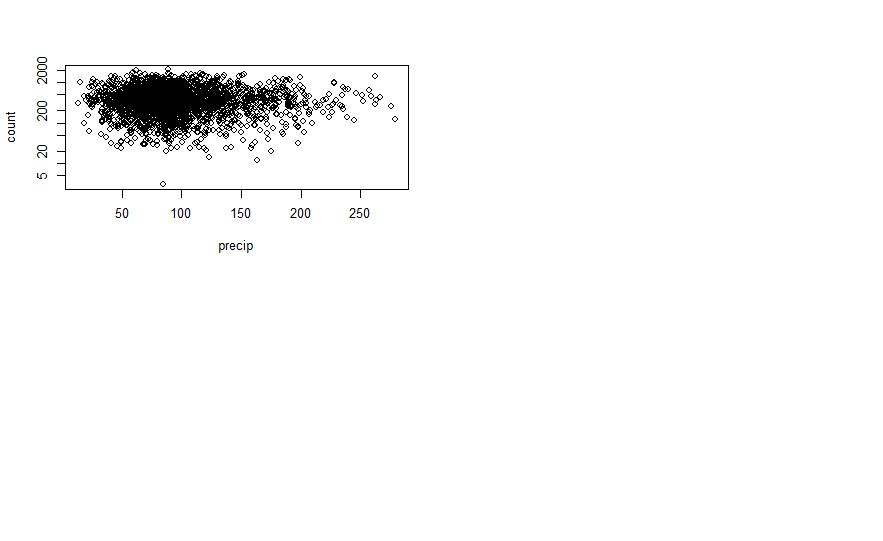

In [7]:
Image('images/Plots/rPlot01.jpg')

So, I was unable to find a correlation for this project. It is possible that the drought signal is not reflected in the cattle sale data when looking at the entire year. Depending on the location the bulk of the catttle sales may occur at late fall, before winter arrives when it is more difficult to maintain cattle weights.  This is probably not the case for Georgia, There are many factors involved and I am not sure how
reflective of overall sale behavior this dataset is. There are alot of missing values, it doesn't take into account private sales or perhaps Georgia doesn't follow the same trends as regions where drought is more common. 

As a back up plan to finding the java code that will access the monthly precip values, I will simulate the precipitation values by finding the mean and standard deviation of the precipitation data and applying markov chains to a forecast style range of years. So I will need to find an R or python code that calculate those figures on the dataset and then use the information from the spatiotemporal process simulation assignment that Dr. Joseph gave us to generate the simulated rain values. However, on second thought, it is not likely that NQPy contains a normal distribution function that I would be able to use. Considering other options. 
    Upon further examination of the possible ways to call upon attributes in a dataset it appears as though it is possible to create an array of precipitation values from the 4th column to the 134th column of the dataframe and use that index, iterated from ranchersB-yID([:4]) to the end to call upon the precip values for each timestep for each agent. 

Okay, backup backup plan; check to see if there is a correlation between rain and cattle weights and use that as a factor weight in the insurance adoption decision instead! So I will need to extract the weights and group them by monthly averages. The average weights of the cows appear to be more precise than the high and low weight ranges given, however I am choosing to take the high range weights from each sale and average those to avoid taking an average of averages.  The figures below show both, and the average weight averages appear to follow the same generaltrend, but I still don't trust it. 

In [10]:
cows = pd.read_csv('data/georgia_cows.csv')
cows.head()

,Unnamed: 0,average_price,class_description,grade_description,head_count,location,price_high,price_low,report_date,selling_basis_description,weight_range_high,weight_range_low,weighted_average,x,y,Unnamed: 15
0,0,262.00,Feeder_Bulls,Medium_and_Large_1,1.0,"Americus, GA",262.0,262.0,4/10/2014,Live,300,250,280.0,-84.232688,32.072386,NaN
1,1,270.00,Feeder_Bulls,Medium_and_Large_1,1.0,"Americus, GA",270.0,270.0,5/1/2014,Live,300,250,295.0,-84.232688,32.072386,NaN
2,2,265.00,Feeder_Bulls,Medium_and_Large_1,1.0,"Americus, GA",265.0,265.0,5/8/2014,Live,300,250,265.0,-84.232688,32.072386,NaN
3,3,304.31,Feeder_Bulls,Medium_and_Large_1,4.0,"Americus, GA",307.0,300.0,6/12/2014,Live,300,250,272.5,-84.232688,32.072386,NaN
4,4,342.50,Feeder_Bulls,Medium_and_Large_1,2.0,"Americus, GA",345.0,340.0,6/19/2014,Live,300,250,265.0,-84.232688,32.072386,NaN


In [11]:
cows['report_date']=pd.to_datetime(cows.report_date)
cows['day'] = cows.report_date.dt.day
cows['month'] = cows.report_date.dt.month
cows['year'] = cows.report_date.dt.year
cows.groupby(['location','year','month']).weighted_average.mean().head()

location      year  month
Americus, GA  2002  8        470.387778
                    9        474.521176
                    10       464.290000
              2004  1        460.609063
                    2        397.605769
Name: weighted_average, dtype: float64

In [12]:
cows.groupby(['location','year','month']).weight_range_high.mean().head()

location      year  month
Americus, GA  2002  8        497.222222
                    9        500.000000
                    10       490.000000
              2004  1        489.062500
                    2        423.076923
Name: weight_range_high, dtype: float64

### With time running out, I forget how to concatenate these values into a new column by intervals. I am going to excel real quick to organize this, I'll be right back.

In [13]:
monthly_weights = cows.groupby(['location','year','month']).weight_range_high.mean()
pd.DataFrame(data=monthly_weights).to_csv('data/monthly_weights2.csv')
cows.to_csv('data/monthly_weights.csv')

In [14]:
df = pd.read_csv('data/weights_precip.csv')
Ashburn = df[df.location=='Ashburn, GA']
Athens = df[df.location=='Athens, GA']
Blackshear = df[df.location=='Blackshear, GA']
Blakely = df[df.location=='Blakely, GA']
#Americus.to_csv('data/americus.csv')

In [15]:
df.head()

,Auction ID,location,Interval,X,Y,precip,weights
0,13,"Americus, GA",2004_01,-84.23,32.07,72.44,489.062500
1,11,"Ashburn, GA",2004_01,-83.65,31.71,99.30,459.615385
2,2,"Athens, GA",2004_01,-83.38,33.96,101.15,487.500000
3,18,"Blackshear, GA",2004_01,-82.24,31.31,85.17,467.500000
4,15,"Blakely, GA",2004_01,-84.93,31.38,91.46,489.473684


In [16]:
plt.scatter(df['precip'], df['weights'])
plt.show()

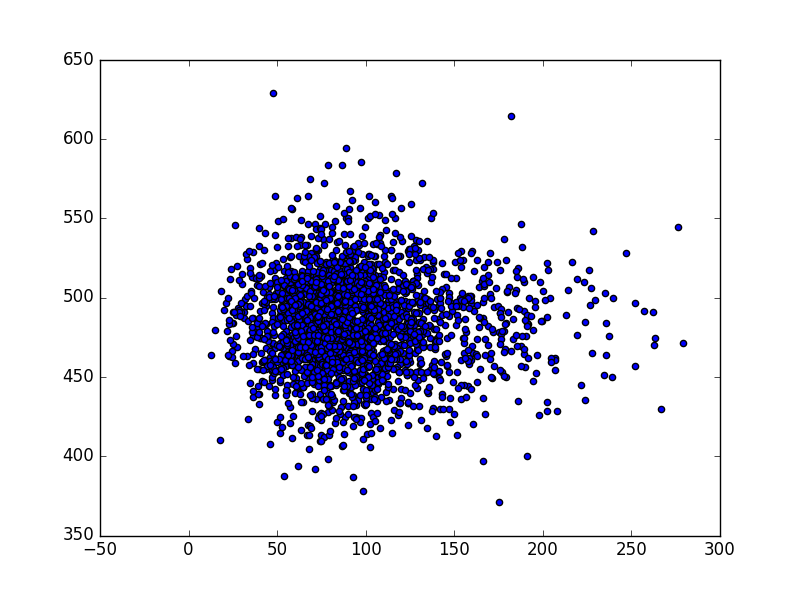

In [18]:
Image('images/weight_precip.png', height = 400, width = 400)

In [ ]:
According to http://gacattle.com/ there are 30,000 cattle producers in Georgia with an average stock of 50. That equates to 
1,500,000 head of cattle.